# Vector indexing with FAISS

Indexing the embedding is a major requiring in case of building any retrieval based system. These index vector stores can also be given to LLM as tool in order to force them to refer and retrieve from given specific information. 

In [6]:
import requests
import pandas as pd
from io import StringIO

In [7]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]

In [43]:
# each of these dataset have the same structure, so we loop through each creating our sentences data
all_sentences = []
for url in urls:
    res = requests.get(url)
    # extract to dataframe
    data = pd.read_csv(StringIO(res.text), sep='\t', header = None, on_bad_lines='skip')
    data.dropna()
    
    # add to columns 1 and 2 to get all sentences together
    all_sentences += data[1].tolist() + data[2].tolist()
    #sentences.extend(data[1].tolist())
    #sentences.extend(data[2].tolist())

# taking unique
all_sentences = list(set([str(sentence) for sentence in all_sentences]))


In [46]:
data[1]

0                         Small dog chews on a big stick.
1                       A tennis player hitting the ball.
2        a lone snowboarder in the middle of a snowy gust
3              A pair of dogs playing with a purple ball.
4                              a bird lands in the water.
                              ...                        
1495                 A man doing a trick on a skateboard.
1496    A young girl in swim goggles does the backstro...
1497                                A deer jumps a fence.
1498    A young girl dressed in a Minnie mouse outfit ...
1499                      a dog sprints across the water.
Name: 1, Length: 1500, dtype: object

In [47]:
#dumping this data for future use
(data[1]+data[2]).to_csv("sample_text_data.csv", header = True, index = False)

In [9]:
len(all_sentences)

9703

## Embedding Model
We will initialize any embedding model to convert queries to vectors

In [10]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [11]:
embed_model = HuggingFaceEmbeddings(model_name = "thenlper/gte-base")

In [12]:
all_sentences_vectors = embed_model.embed_documents(all_sentences)

In [13]:
len(all_sentences_vectors), len(all_sentences_vectors[1])

(9703, 768)

## Basic Vector Index
The very basic index in Faiss would be a flat index (simple array of vectors) using Euclidean distance (L2) as distance metric. 

This index would essentially use brute force to get k similar vectors to given query vector (that is comparing the query vector with all given vectors)
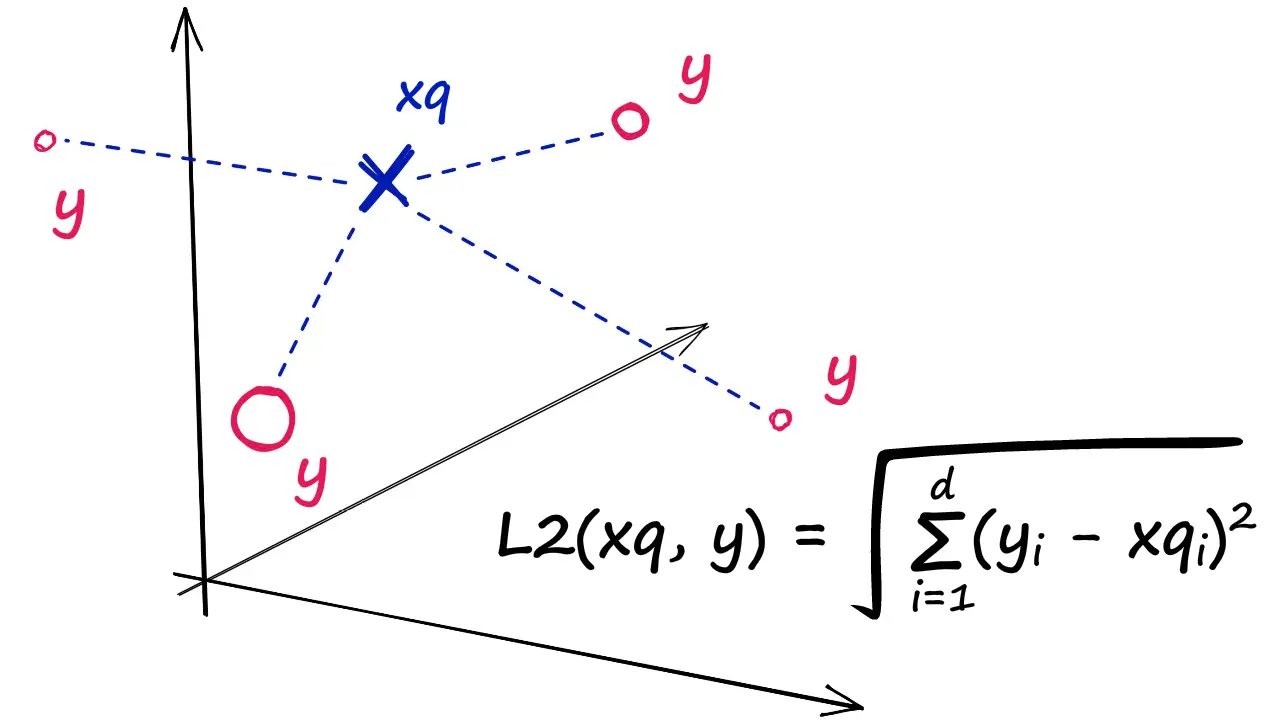
This basic index is not a trained vector.

In [14]:
import faiss
import numpy as np

In [15]:
all_sentences_vectors = np.array(all_sentences_vectors)

In [16]:
# index is created with passing the dimension of vector
embed_dims = all_sentences_vectors.shape[1]
flat_index = faiss.IndexFlatL2(embed_dims)

#adding all the sentences vector in this
flat_index.add(all_sentences_vectors)
flat_index.ntotal

9703

In [17]:
#searching 
query = all_sentences[20]
query_encoded = np.array(embed_model.embed_query(query)).reshape(1, -1)

In [18]:
query

'Red double decker bus with hood open.'

In [19]:
# d is the distance measure matrix and indices are the k similar indices
D, indices = flat_index.search(query_encoded, 4)
indices.shape

(1, 4)

In [20]:
[all_sentences[idx] for idx in indices[0] ]

['Red double decker bus with hood open.',
 'Red double decker bus with hood up.',
 'An old Red London double decker bus with its hood raised.',
 'Red double decker bus.']

## Clustered Faiss Index
To handle bigger vector store, Faiss offers divided the given vector datbase into clusters,
(VORONOI CELLS) each cluster has a centroid and list of vectors in that cluster. 

When a query comes, nearest clustered is identified by comparing it with centroids.
The top k retrieval only happens in the nearest cluster. This way the search scope is narrowed down.

Also, in case if we want to expand the search space, we can increase the number of clusters to search with a parameter

Using this method, we would take a query vector xq, identify the cell it belongs to, and then use our IndexFlatL2 (or another metric) to search between the query vector and all other vectors belonging to that specific cell.

Hence the flatindex would be called as quantizer for the clustered index
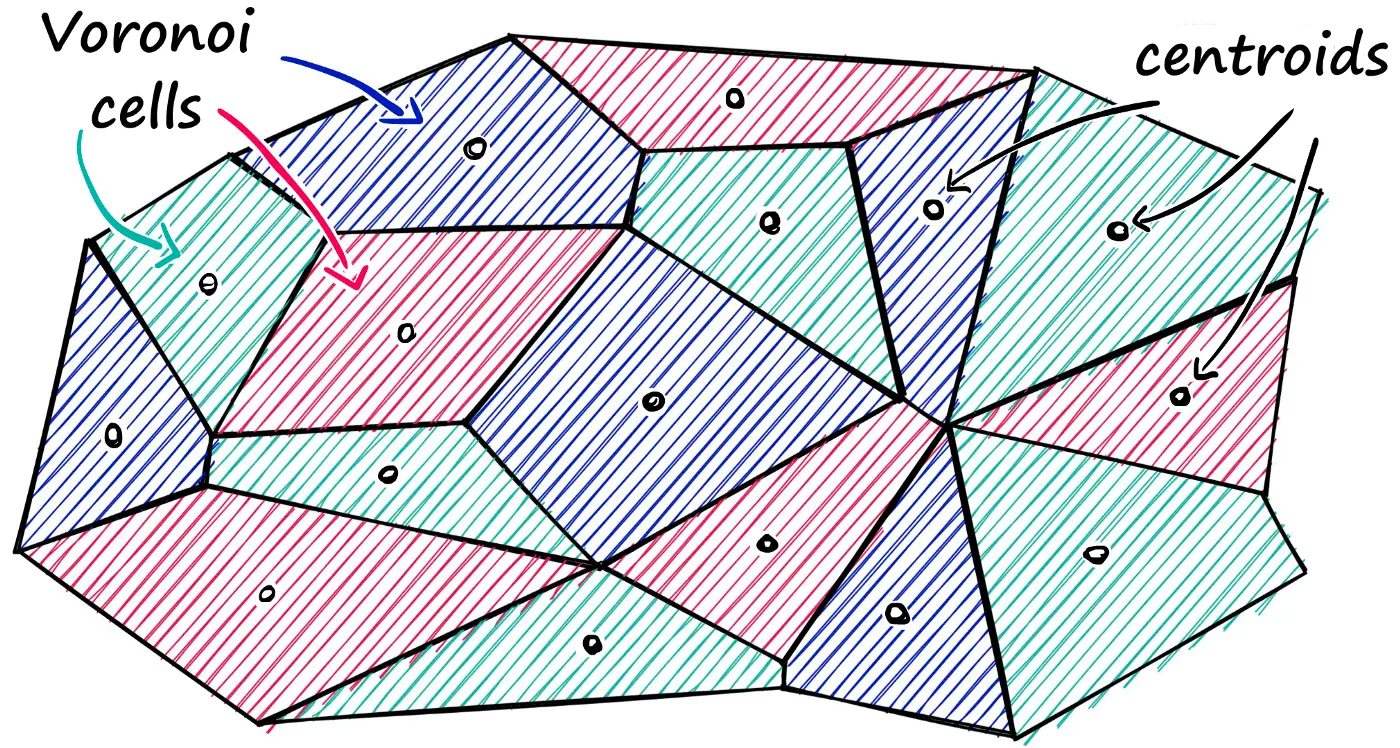

In [16]:
# we will use the same dimension and same embeddings
num_clusters = 5
quantizer = faiss.IndexFlatL2(embed_dims)

In [38]:
clustered_index = faiss.IndexIVFFlat(quantizer, embed_dims, num_clusters)

In [ ]:
# now we have to train this index with the vector emebddings (this will form clusters)
clustered_index.train(all_sentences_vectors)

In [2]:
# parameter to increase search scope of search in cells
clustered_index.nprobe = 5 # will search 5 cells

'1.7.4'

# Vector Quantization 
In case database in still very large, faiss has the option of breaking the vector into pieces to cluster. 
All of our indexes so far have stored our vectors as full (eg Flat) vectors. Now, in very large datasets this can quickly become a problem.

Faiss comes with the ability to compress our vectors using `Product Quantization` (PQ).
PQ achieves this approximated similarity operation by compressing the vectors themselves, which consists of three steps.

1. We split the original vector into several subvectors.
2. For each set of subvectors, we perform a clustering operation — creating multiple centroids for each sub-vector set.
3. In our vector of sub-vectors, we replace each sub-vector with the ID of it’s nearest set-specific centroid.

Time difference would be noticable in cases when the vector database is too large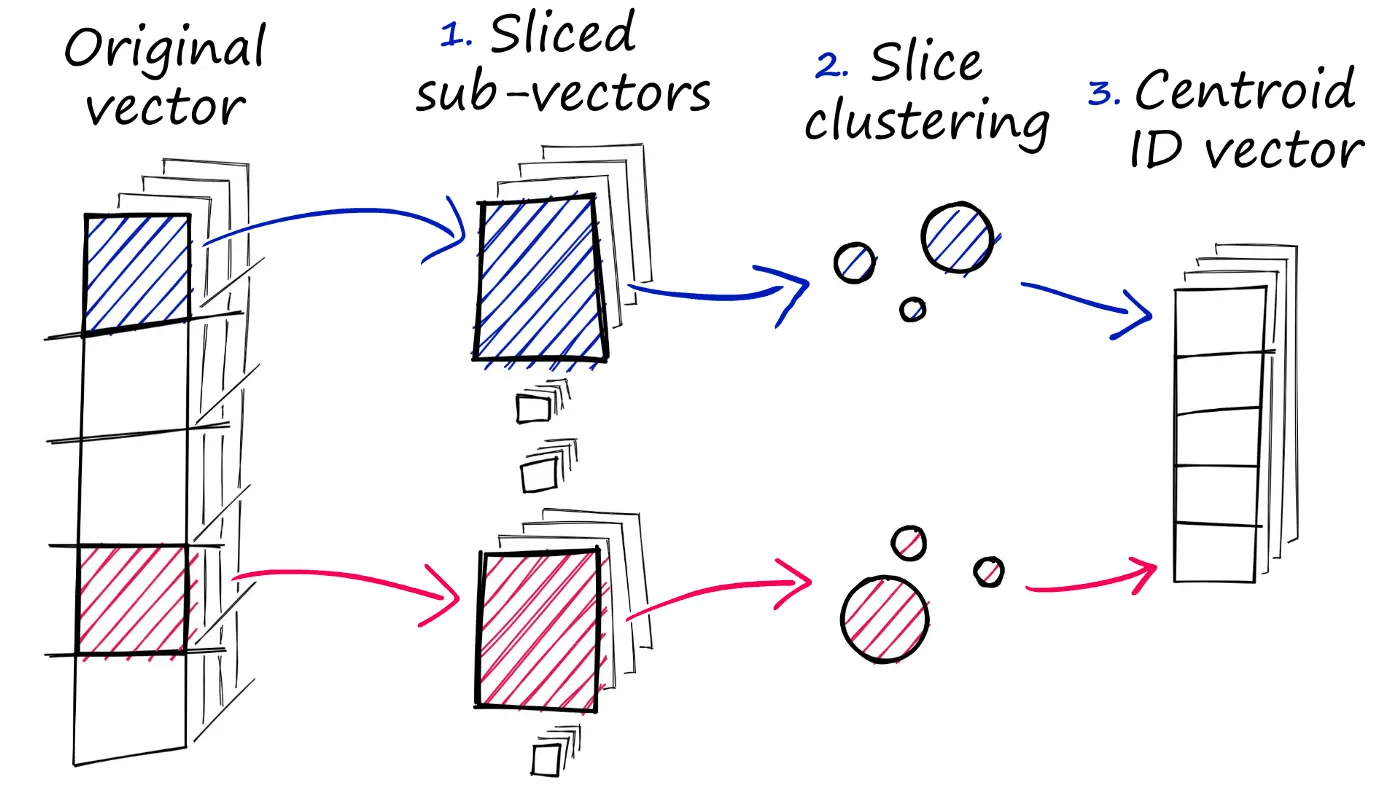

In [2]:
num_centroid_ids = 8 # final number of centroid ids for every vector
num_bits = 8 # number of bits in each centroid

In [3]:
pq_cluster_index = faiss.IndexIVFPQ(quantizer, embed_dims, num_clusters, num_centroid_ids, num_bits)

NameError: name 'faiss' is not defined

In [4]:
pq_cluster_index.train(all_sentences_vectors)

NameError: name 'pq_cluster_index' is not defined

In [ ]:
# searching process is same

## Langchain-Faiss integration

Langchain also provides vector store class which can be used to perform operations 
in langchain

LangChain provides a standard interface for working with vector stores, allowing users to easily switch between different vectorstore implementations.

The interface consists of basic methods for writing, deleting and searching for documents in the vector store.

The key methods are:

`add_documents`: Add a list of texts (langchain document) to the vector store. 

`delete`: Delete a list of documents from the vector store.

`similarity_search`: Search for similar documents to a given query.

#### Langchain vector store adds documents into the vector stores with each unique ID to a document
#### and then uses vector index to convert to embeddings

In [25]:
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [24]:
langchain_index = faiss.IndexFlatL2(embed_dims)

In [26]:
vector_store = FAISS(embedding_function = embed_model,
                    index = langchain_index,
                    docstore = InMemoryDocstore(),
                    index_to_docstore_id = {})

In [35]:
from langchain_core.documents import Document

all_documents = [ Document(
    page_content = sentence,
    metadata = {"source": "raw_data"})
                 for sentence in all_sentences ]

In [37]:
vector_store.add_documents(documents = all_documents,
                          ids = list(range(len(all_documents))))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [1]:
# can now directly use similarity search in langchain directly 
# to access nearest vectors

In [41]:
similar_vectors = vector_store.similarity_search(query, k = 4)

In [42]:
similar_vectors

[Document(id='20', metadata={'source': 'raw_data'}, page_content='Red double decker bus with hood open.'),
 Document(id='7114', metadata={'source': 'raw_data'}, page_content='Red double decker bus with hood up.'),
 Document(id='3606', metadata={'source': 'raw_data'}, page_content='An old Red London double decker bus with its hood raised.'),
 Document(id='5849', metadata={'source': 'raw_data'}, page_content='Red double decker bus.')]